# Bike Sharing Demand Analysis
## Data Preprocessing and Initial Exploration

In this notebook, we will analyze the bike sharing demand dataset to understand patterns and build predictive models. The dataset contains daily records of bike rentals along with weather conditions and temporal information.

## About the Dataset

This dataset contains the daily and hourly count of rental bikes between years 2011 and 2012 in the Capital bikeshare system with the corresponding weather and seasonal information. The data was obtained from the Capital Bikeshare program in Washington, D.C., which was collected and made available by the UCI Machine Learning Repository.

The dataset includes the following files:
- `day.csv`: Daily rental data spanning two years
- `hour.csv`: Hourly rental data spanning two years

This analysis will focus on the daily rental patterns using the `day.csv` file, which contains information about:
- Weather conditions (temperature, humidity, windspeed)
- Calendar information (holiday, weekday, month, season)
- Rental counts (casual, registered, and total users)

Source: [UCI Machine Learning Repository - Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

### Setup and Data Loading

First, we import the necessary libraries for our analysis:
- `pandas` for data manipulation
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for visualization
- `sklearn` for machine learning tools

In [32]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

def load_bike_sharing_data(filepath):
    """
    Load and return bike sharing dataset
    Args:
        filepath (str): Path to the CSV file
    Returns:
        pd.DataFrame: Loaded bike sharing dataset
    """
    try:
        data = pd.read_csv(filepath)
        print(f"Dataset loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns")
        return data
    except FileNotFoundError:
        print(f"Error: File {filepath} not found")
        return None
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None

# Set basic plot configurations
plt.rcParams['figure.figsize'] = [10, 6]
sns.set_theme(style="whitegrid")

# Load the dataset
filepath = 'day.csv'
bike_data = load_bike_sharing_data(filepath)

# Display first rows if data loaded successfully
if bike_data is not None:
    print("\nFirst few rows of the dataset:")
    display(bike_data.head())

Dataset loaded successfully with 731 rows and 16 columns

First few rows of the dataset:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Data Visualization

Let's explore the distribution of our target variable and its relationships with key features:

1. First, we'll look at the distribution of total bike rentals (`cnt`) using a histogram with a KDE (Kernel Density Estimation) line to understand the overall pattern of bike usage.

2. Then, we'll create a pair plot to visualize relationships between:
  - Temperature (`temp`)
  - Feels-like temperature (`atemp`)
  - Humidity (`hum`)
  - Wind speed (`windspeed`)
  - Total rentals (`cnt`)

This will help us identify potential patterns and correlations between weather conditions and bike rental demand.

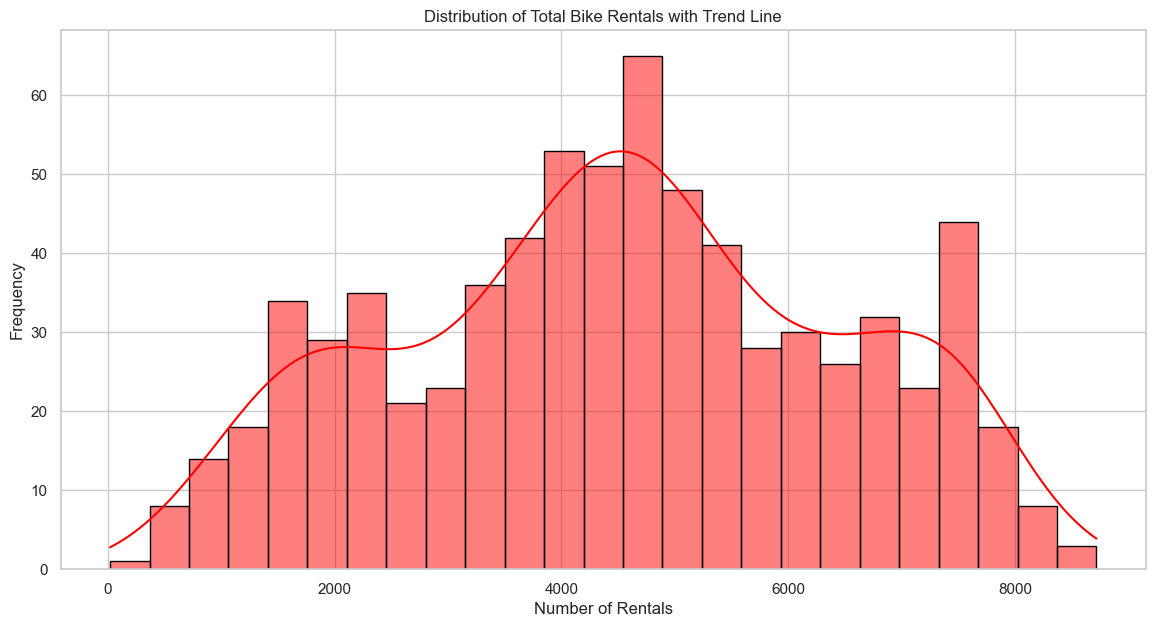

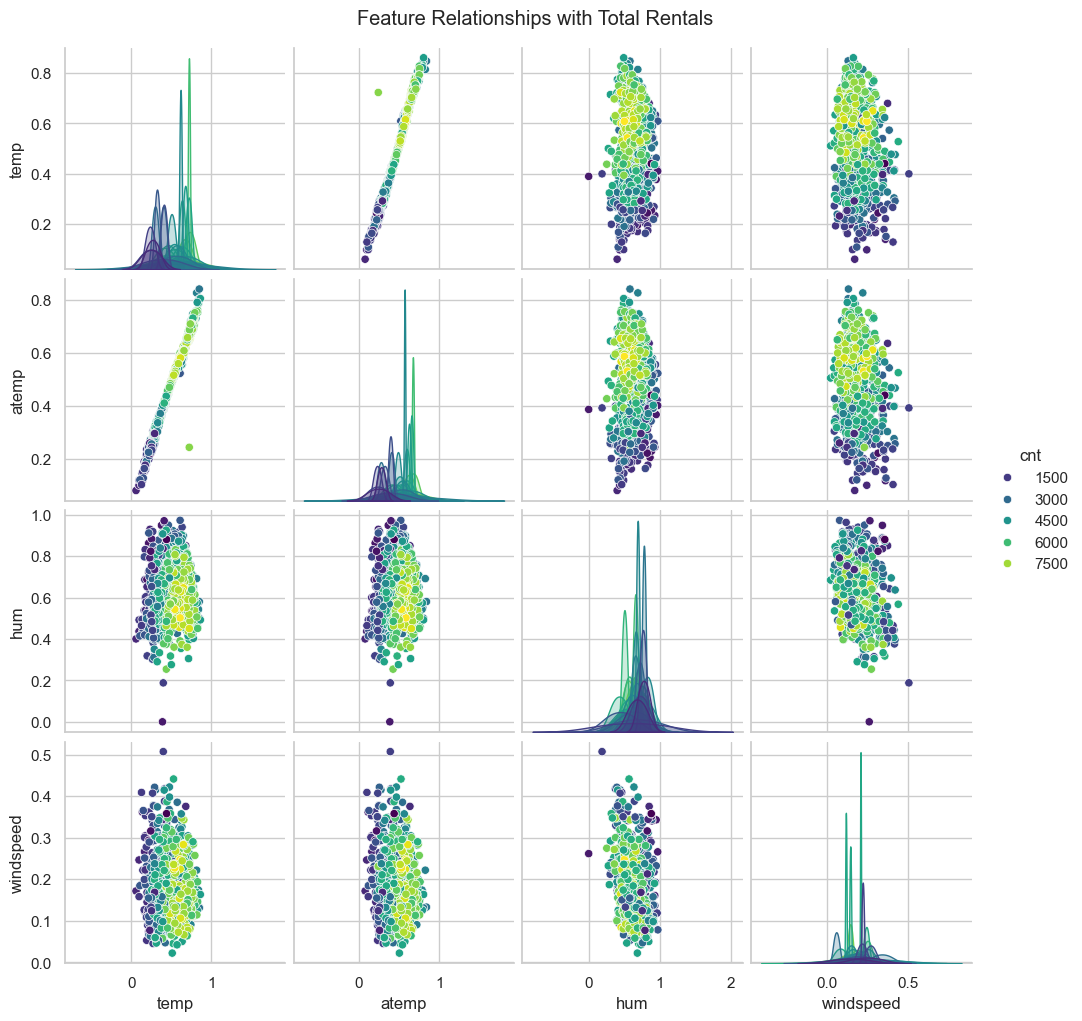

In [34]:
# Create visualizations of bike rental distributions and relationships
def plot_rental_distribution(data):
    """
    Creates a histogram of total bike rentals with KDE trend line
    Args:
        data (pd.DataFrame): Bike sharing dataset
    """
    plt.figure(figsize=(14, 7))
    sns.histplot(
        data=data,
        x='cnt',
        bins=25,
        kde=True,
        color='red',
        edgecolor='black',
        stat='count'
    )
    plt.title('Distribution of Total Bike Rentals with Trend Line')
    plt.xlabel('Number of Rentals')
    plt.ylabel('Frequency')
    plt.show()

def plot_feature_relationships(data, features):
    """
    Creates a pair plot showing relationships between selected features
    Args:
        data (pd.DataFrame): Bike sharing dataset
        features (list): List of features to analyze
    """
    subset_data = data[features]
    sns.pairplot(
        data=subset_data,
        kind='scatter',
        hue='cnt',
        palette='viridis'
    )
    plt.suptitle('Feature Relationships with Total Rentals', y=1.02)
    plt.show()

# Selected features for analysis
selected_features = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Generate visualizations
plot_rental_distribution(bike_data)
plot_feature_relationships(bike_data, selected_features)

### Data Cleaning and Feature Selection

First, we'll remove the date column ('dteday') since we already have the date information broken down into more useful features like year, month, and season. This will help us focus on the numerical relationships in our data.

Note: We keep 'instant' as it serves as our index identifier, but it won't be used as a feature for our analysis.

In [36]:
# Remove date column as we have temporal features already
bike_data = bike_data.drop(columns=['dteday'])

# Display the first rows of our cleaned dataset
print(bike_data.head())

   instant  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0        1       1   0     1        0        6           0           2   
1        2       1   0     1        0        0           0           2   
2        3       1   0     1        0        1           1           1   
3        4       1   0     1        0        2           1           1   
4        5       1   0     1        0        3           1           1   

       temp     atemp       hum  windspeed  casual  registered   cnt  
0  0.344167  0.363625  0.805833   0.160446     331         654   985  
1  0.363478  0.353739  0.696087   0.248539     131         670   801  
2  0.196364  0.189405  0.437273   0.248309     120        1229  1349  
3  0.200000  0.212122  0.590435   0.160296     108        1454  1562  
4  0.226957  0.229270  0.436957   0.186900      82        1518  1600  


### Feature Correlation Analysis

Now we'll analyze the relationships between all variables in our dataset, with special attention to correlations with our target variable 'cnt' (total rentals):

1. First, we create a correlation matrix heatmap to visualize all variable relationships at once
  - Darker colors indicate stronger correlations
  - Values range from -1 (perfect negative correlation) to 1 (perfect positive correlation)

2. Then, we'll sort the correlations specifically with our target variable 'cnt'
  - This will help us identify the most important features for our model
  - Higher absolute values indicate stronger relationships with bike rentals

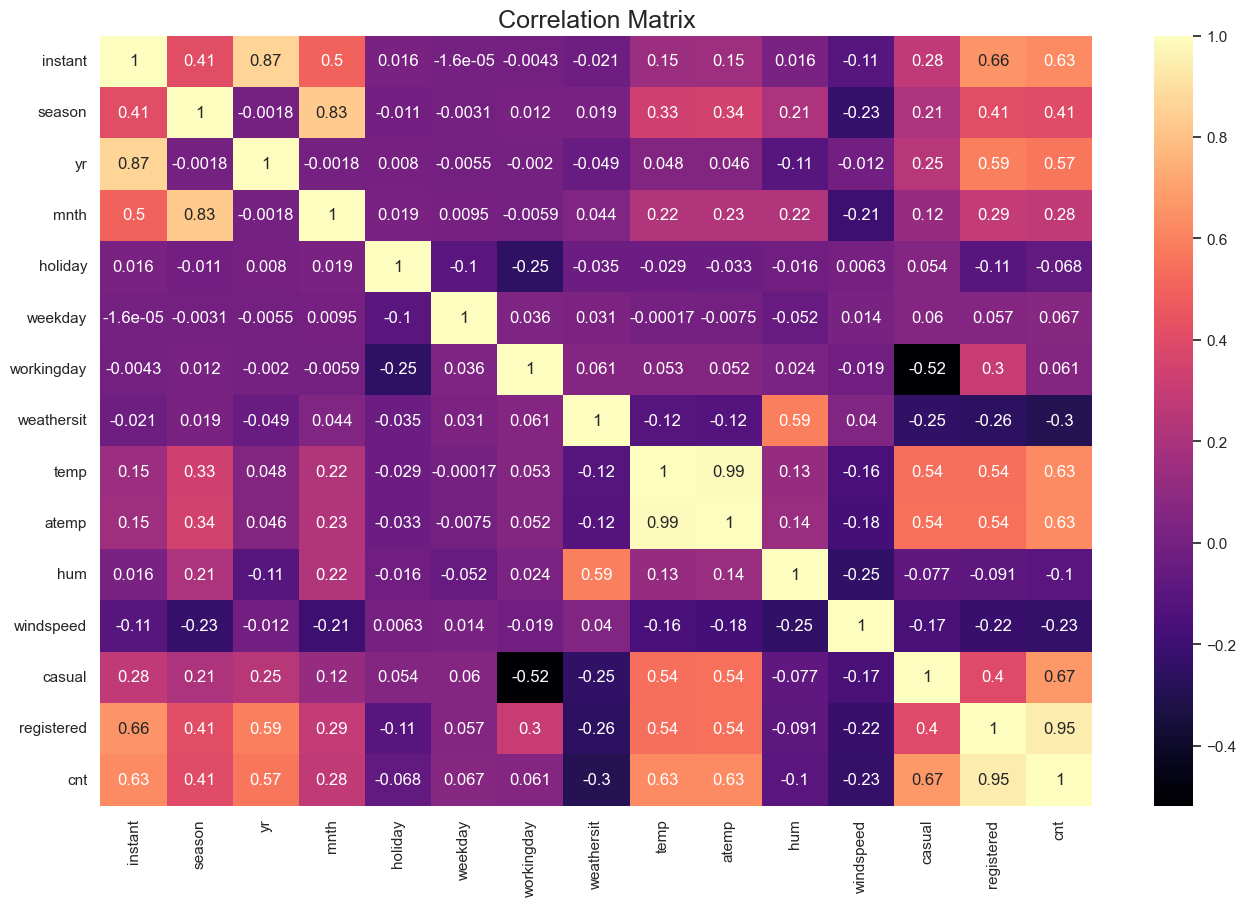


Correlations with total rentals (cnt):
cnt           1.000000
registered    0.945517
casual        0.672804
atemp         0.631066
instant       0.628830
temp          0.627494
yr            0.566710
season        0.406100
mnth          0.279977
weekday       0.067443
workingday    0.061156
holiday      -0.068348
hum          -0.100659
windspeed    -0.234545
weathersit   -0.297391
Name: cnt, dtype: float64


In [39]:
# Create correlation matrix and visualize it
correlation_matrix = bike_data.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='magma')
plt.title('Correlation Matrix', fontsize=18)
plt.show()

# Display sorted correlations with target variable
correlation_with_cnt = bike_data.corr()['cnt'].sort_values(ascending=False)
print("\nCorrelations with total rentals (cnt):")
print(correlation_with_cnt)   # We'll choose the highest correlated features

### Understanding Correlations with Bike Rentals

The correlation analysis reveals several interesting patterns:

#### Strong Positive Correlations (> 0.6)
- `registered` (0.95): Very strong correlation, indicating registered users are the main drivers of total rentals
- `casual` (0.67): Strong correlation but less than registered users
- `atemp` (0.63): Feels-like temperature has a strong positive impact
- `temp` (0.63): Actual temperature shows similar correlation to feels-like temperature
- `instant` (0.63): Shows upward trend in rentals over time

#### Moderate Positive Correlations (0.3-0.6)
- `yr` (0.57): Yearly trend shows growing usage
- `season` (0.41): Seasonal patterns affect rentals

#### Weak Correlations (-0.3 to 0.3)
- `mnth` (0.28): Monthly variation has limited impact
- `weekday` (0.07): Day of week shows minimal effect
- `workingday` (0.06): Surprisingly low impact
- `holiday` (-0.07): Slight negative impact
- `hum` (-0.10): Higher humidity slightly decreases rentals
- `windspeed` (-0.23): Moderate negative impact
- `weathersit` (-0.30): Worse weather conditions decrease rentals

These correlations will help us select the most relevant features for our predictive model.

### Multicollinearity Check with VIF

After identifying the highest correlated features with our target variable ('cnt'), we'll check for multicollinearity among these features using the Variance Inflation Factor (VIF). VIF is important because:

- It measures how much the variance of a regression coefficient is inflated due to multicollinearity
- A VIF of 1 means no correlation
- VIF values greater than 5 or 10 typically indicate problematic multicollinearity
- High multicollinearity can make our model unstable

We'll analyze the VIF for our top correlated features:
- registered
- casual
- atemp (feels-like temperature)
- instant (time index)

In [43]:
# Calculate VIF for top correlated features
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select features for VIF analysis
X = bike_data[['registered', 'casual', 'atemp', 'instant']]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print("Variance Inflation Factors:")
print(vif_data)

Variance Inflation Factors:
      Feature        VIF
0  registered  17.891634
1      casual   3.620711
2       atemp  10.868833
3     instant   7.445790


### VIF Analysis Results

The Variance Inflation Factor analysis reveals potential multicollinearity issues:

1. **High Multicollinearity** (VIF > 10):
  - `registered` (VIF = 17.89): Shows very high multicollinearity
  - `atemp` (VIF = 10.87): Just above the threshold

2. **Moderate Multicollinearity** (5 < VIF < 10):
  - `instant` (VIF = 7.45): Shows moderate multicollinearity

3. **Acceptable Range** (VIF < 5):
  - `casual` (VIF = 3.62): Shows acceptable level of correlation


### Linear Regression Model Implementation

Now we'll implement a Linear Regression model to predict bike rentals. Despite the multicollinearity identified in our VIF analysis, we'll include all highly correlated features initially to establish a baseline model.

Selected features:
- registered
- casual
- atemp (feels-like temperature)
- instant (time index)
- temp (actual temperature)

The model will:
1. Split the data into training (80%) and testing (20%) sets
2. Train a Linear Regression model
3. Make predictions on the test set
4. Evaluate performance using:
  - Mean Squared Error (MSE)
  - R-squared (R²) score
  - Visual comparison of predicted vs actual values

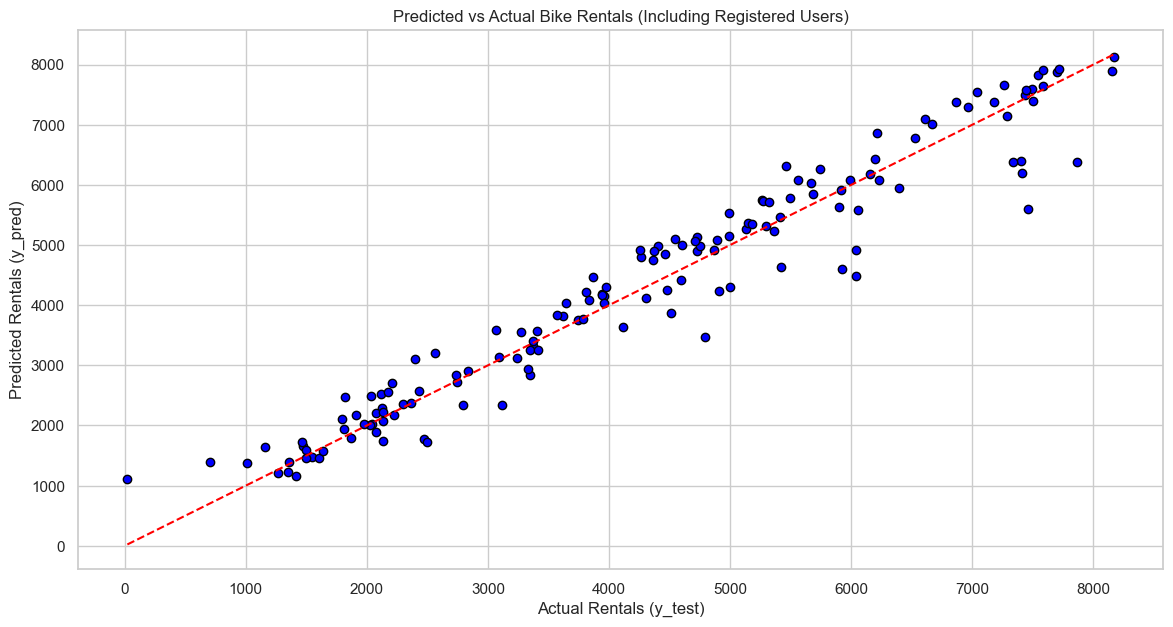

Mean Squared Error (MSE): 237823.55265349752
R-squared (R²): 0.9406906398897033


In [52]:
# Import required libraries and prepare data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target variable
X = bike_data[['registered', 'atemp', 'instant', 'temp']]  
y = bike_data['cnt']  

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and create visualization
y_pred = model.predict(X_test)
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_pred, color='blue', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--')  
plt.title('Predicted vs Actual Bike Rentals (Including Registered Users)')
plt.xlabel('Actual Rentals (y_test)')
plt.ylabel('Predicted Rentals (y_pred)')
plt.grid(True)
plt.show()

# Calculate and display performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

### Model Performance Analysis - Including 'registered' Users

Let's analyze the results of our Linear Regression model that includes 'registered' users as a feature along with environmental factors (temperature, feels-like temperature) and temporal data:

The model achieved:
- A very high R² score of 0.941 (94.1% accuracy)
- A Mean Squared Error of 237,823

What does this mean?
1. The Good News: Our model is extremely accurate at predicting total rentals
  - Only a ~6% margin of error
  - Average prediction error of about 488 bikes per day

2. The Reality Check: This is too good to be true
  - The high accuracy comes from using 'registered' users as a feature
  - Think of it like trying to predict a pizza's total weight while knowing the weight of the crust
  - In real life, we wouldn't know the number of registered users in advance

3. The Lesson Learned:
  - We need to focus on features we would actually have available for prediction
  - Environmental and temporal factors alone might be more realistic predictors
  - Future models should exclude 'registered' and 'casual' user counts

### Model Comparison - With vs Without 'registered' Users

Let's run a comparative analysis to understand the impact of using 'registered' users as a feature. We'll create two models:
1. Model A: Including 'registered' users (along with environmental and temporal features)
2. Model B: Only using features available for real predictions

This comparison will help us:
- Understand how much predictive power we lose when removing 'registered' users
- Set realistic expectations for our model's performance
- Identify the true predictive power of our environmental and temporal features

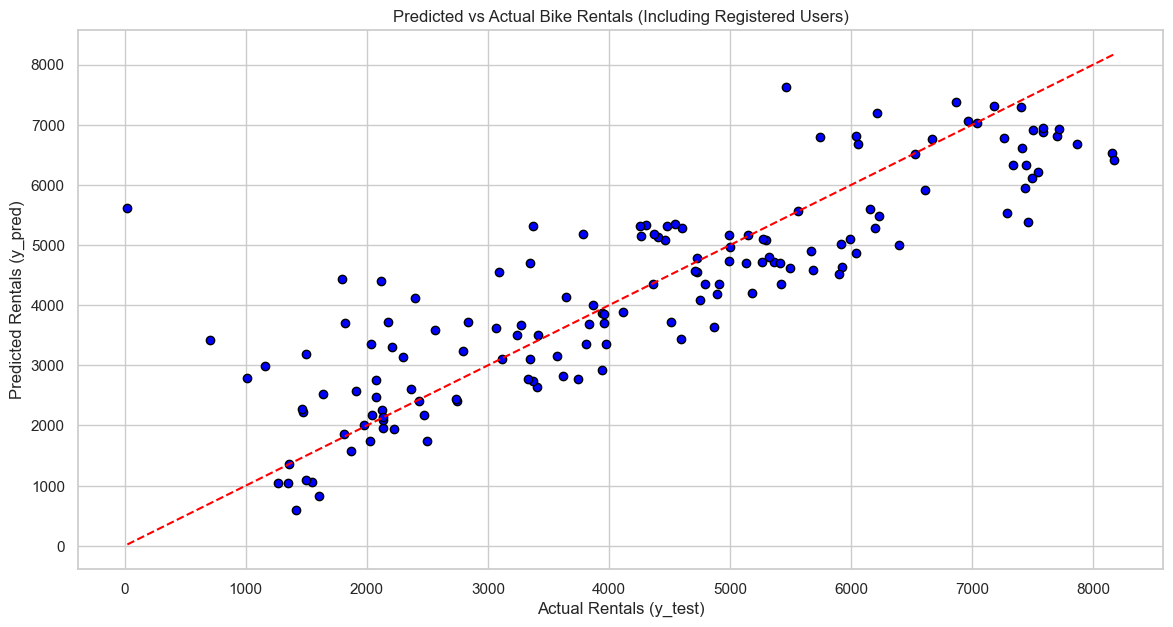

Mean Squared Error (MSE): 1081936.1359783898
R-squared (R²): 0.7301825694338282


In [58]:
# Select features and target variable
X = bike_data[['yr', 'atemp', 'instant', 'temp']]  
y = bike_data['cnt']  

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and create visualization
y_pred = model.predict(X_test)
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_pred, color='blue', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--')  
plt.title('Predicted vs Actual Bike Rentals (Including Registered Users)')
plt.xlabel('Actual Rentals (y_test)')
plt.ylabel('Predicted Rentals (y_pred)')
plt.grid(True)
plt.show()

# Calculate and display performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

### Model Performance Comparison

Comparing our two models reveals the significant impact of feature selection:

#### Model with 'registered' users:
- R² = 0.941 (94.1% accuracy)
- MSE = 237,823
- Avg error ≈ 488 bikes/day

#### Model with 'yr' instead of 'registered':
- R² = 0.730 (73.0% accuracy)
- MSE = 1,081,936
- Avg error ≈ 1,040 bikes/day

Key Insights:
1. While the accuracy dropped significantly, this second model is more realistic and useful
2. The 73% accuracy is actually quite good for real-world predictions
3. The year variable ('yr') does add some predictive power, improving our R² from 0.698 to 0.730
4. This suggests that bike rentals have some yearly trends that help with predictions

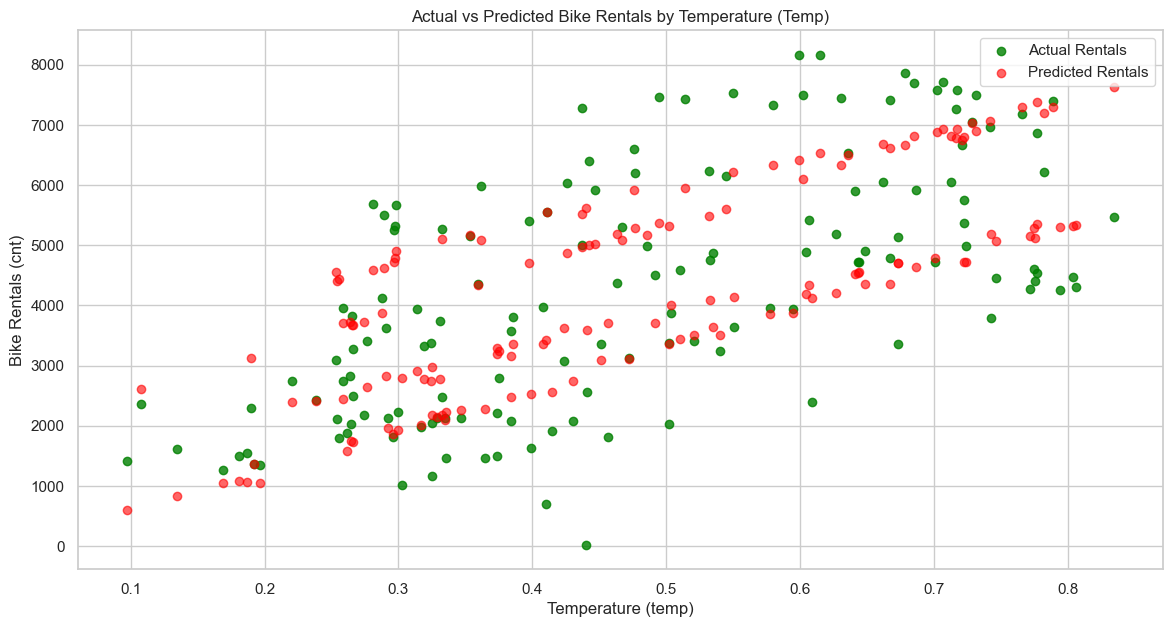


Largest differences between prediction and actual value:
     Temperature  Actual    Predicted   Difference     abs_diff
667     0.440000      22  5612.300644  5590.300644  5590.300644
340     0.410000     705  3422.166231  2717.166231  2717.166231
729     0.255833    1796  4442.094844  2646.094844  2646.094844
726     0.254167    2114  4404.439207  2290.439207  2290.439207
545     0.834167    5463  7632.449851  2169.449851  2169.449851
469     0.495000    7460  5374.472278 -2085.527722  2085.527722
448     0.502500    3372  5317.532790  1945.532790  1945.532790
319     0.456667    1817  3698.776445  1881.776445  1881.776445
360     0.325000    1162  2980.360082  1818.360082  1818.360082
357     0.302500    1011  2791.016311  1780.016311  1780.016311

Average error by temperature range:
                       mean  count
Temperature                       
(0.0967, 0.245] -211.036226     11
(0.245, 0.392]   102.217522     47
(0.392, 0.539]    49.282371     34
(0.539, 0.687]  -518.22556

In [93]:
# Predicting and plotting results for the 'temp' feature
X = bike_data[['yr', 'atemp', 'instant', 'temp']] 
y = bike_data['cnt']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Create visualization
plt.figure(figsize=(14, 7))
plt.scatter(X_test['temp'], y_test, color='green', label='Actual Rentals', alpha=0.8)
plt.scatter(X_test['temp'], y_pred, color='red', label='Predicted Rentals', alpha=0.6)
plt.title('Actual vs Predicted Bike Rentals by Temperature (Temp)')
plt.xlabel('Temperature (temp)')
plt.ylabel('Bike Rentals (cnt)')
plt.legend()
plt.show()
# Create analysis DataFrame
analysis_df = pd.DataFrame({
    'Temperature': X_test['temp'],
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_pred - y_test
})
# Sort by absolute difference to see largest discrepancies
print("\nLargest differences between prediction and actual value:")
print(analysis_df.assign(abs_diff=abs(analysis_df['Difference']))
      .sort_values('abs_diff', ascending=False)
      .head(10))
# Group by temperature ranges to see where model performs better/worse
temp_ranges = pd.cut(analysis_df['Temperature'], bins=5)
print("\nAverage error by temperature range:")
print(analysis_df.groupby(temp_ranges, observed=True)['Difference'].agg(['mean', 'count']))

### Prediction Error Analysis by Temperature

Analyzing the differences between actual values and predictions:

#### Largest Discrepancies:
1. Biggest error: At temperature 0.44, the model predicted 5,612 bikes when only 22 were actually rented
  - Significant overestimation of +5,590 bikes
2. Second case: At temperature 0.41, predicted 3,422 vs actual 705
  - Overestimation of +2,717 bikes
3. Pattern: The model tends to significantly overestimate at medium-low temperatures

#### Analysis by Temperature Ranges:
1. Very low temperatures (0.097-0.245):
  - Underestimates by an average of 211 bikes
  - 11 cases in this range

2. Low-medium temperatures (0.245-0.392):
  - Overestimates by an average of 102 bikes
  - Highest number of cases (47)

3. Medium temperatures (0.392-0.539):
  - Slight overestimation (49 bikes)
  - 34 cases

4. Medium-high temperatures (0.539-0.687):
  - Significant underestimation (-518 bikes)
  - 28 cases

5. High temperatures (0.687-0.834):
  - Overestimates by an average of 359 bikes
  - 27 cases

This analysis suggests that the model struggles to predict accurately at temperature extremes, especially at medium-high temperatures where it tends to significantly underestimate the number of rentals.

### Linear Regression Model with Extended Features

For our current analysis, we'll enhance our Linear Regression model by including additional relevant features:
- Year (`yr`)
- Feels-like temperature (`atemp`)
- Time index (`instant`)
- Temperature (`temp`)
- Season (`season`)
- Month (`mnth`)
- Wind speed (`windspeed`)
- Weather situation (`weathersit`)

This will help us understand if additional weather and temporal features improve our predictions. We'll:
1. Train the model with these extended features
2. Visualize actual vs predicted rentals
3. Analyze prediction errors across different temperature ranges
4. Compare results with our previous simpler model

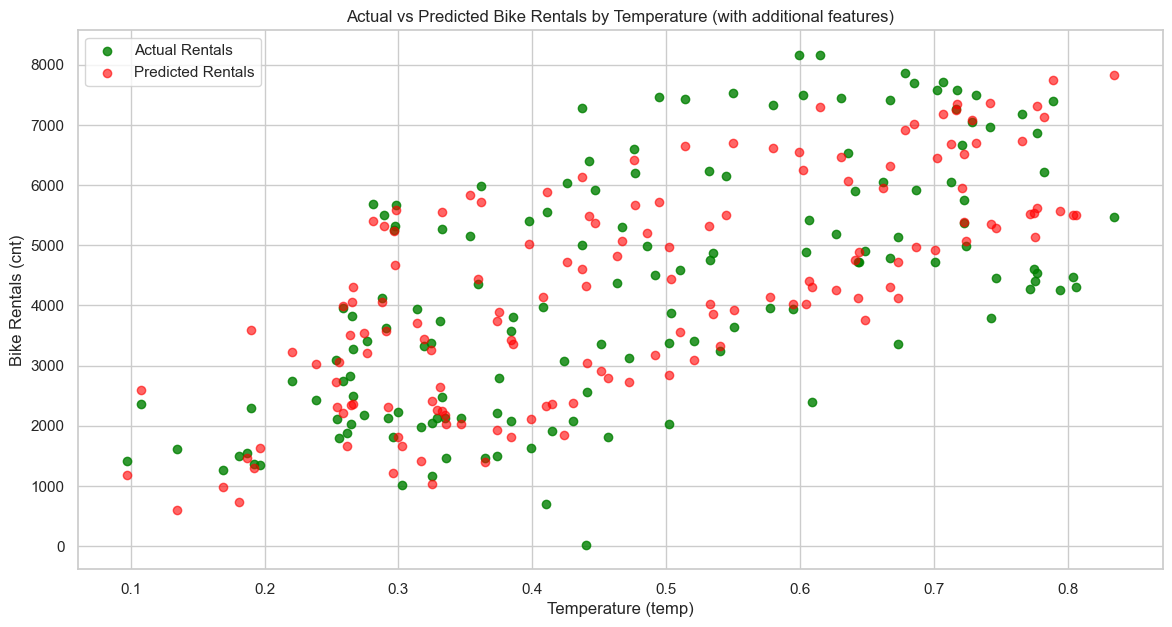


Largest differences between predicted and actual values:
     Temperature  Actual    Predicted   Difference     abs_diff
667     0.440000      22  4327.080749  4305.080749  4305.080749
545     0.834167    5463  7835.486032  2372.486032  2372.486032
327     0.373333    1495  3741.730034  2246.730034  2246.730034
265     0.609167    2395  4298.167378  1903.167378  1903.167378
469     0.495000    7460  5720.247030 -1739.752970  1739.752970
629     0.599167    8167  6542.058597 -1624.941403  1624.941403
340     0.410000     705  2324.159145  1619.159145  1619.159145
448     0.502500    3372  4964.612064  1592.612064  1592.612064
218     0.742500    3785  5352.930233  1567.930233  1567.930233
375     0.274167    2177  3540.623530  1363.623530  1363.623530

Average error by temperature range:
                       mean  count
Temperature                       
(0.0967, 0.245]   39.781137     11
(0.245, 0.392]    81.929985     47
(0.392, 0.539]   -83.455213     34
(0.539, 0.687]  -510.09758

In [74]:
# Predicting and plotting results with more features
X = bike_data[['yr', 'atemp', 'instant', 'temp', 'season', 'mnth', 'windspeed', 'weathersit']]
y = bike_data['cnt']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Create visualization
plt.figure(figsize=(14, 7))
plt.scatter(X_test['temp'], y_test, color='green', label='Actual Rentals', alpha=0.8)
plt.scatter(X_test['temp'], y_pred, color='red', label='Predicted Rentals', alpha=0.6)
plt.title('Actual vs Predicted Bike Rentals by Temperature (with additional features)')
plt.xlabel('Temperature (temp)')
plt.ylabel('Bike Rentals (cnt)')
plt.legend()
plt.show()

# Create analysis DataFrame
analysis_df = pd.DataFrame({
   'Temperature': X_test['temp'],
   'Actual': y_test,
   'Predicted': y_pred,
   'Difference': y_pred - y_test
})

# Sort by absolute difference to see largest discrepancies
print("\nLargest differences between predicted and actual values:")
print(analysis_df.assign(abs_diff=abs(analysis_df['Difference']))
     .sort_values('abs_diff', ascending=False)
     .head(10))

# Group by temperature ranges to see where model performs better/worse
temp_ranges = pd.cut(analysis_df['Temperature'], bins=5)
print("\nAverage error by temperature range:")
print(analysis_df.groupby(temp_ranges, observed=True)['Difference'].agg(['mean', 'count']))

### Performance Analysis with Additional Features

Comparing this with our previous model, we can observe some changes:

#### Largest Discrepancies Analysis:
1. Biggest error improvement:
  - Previous: 5,590 bikes overestimation at temp 0.44
  - Current: 4,305 bikes overestimation at same temp
  - ~23% improvement in worst-case prediction

2. Overall error pattern:
  - Still shows significant overestimation in some cases
  - Most large errors occur at temperature extremes
  - The magnitude of errors has generally decreased

#### Temperature Range Analysis:
1. Very low temperatures (0.097-0.245):
  - Previous: -211 bikes (underestimation)
  - Current: +40 bikes (slight overestimation)
  - Significant improvement in this range

2. Low-medium temperatures (0.245-0.392):
  - Previous: +102 bikes
  - Current: +82 bikes
  - Slight improvement in accuracy

3. Medium temperatures (0.392-0.539):
  - Previous: +49 bikes
  - Current: -83 bikes
  - Shifted from over to underestimation

4. Medium-high temperatures (0.539-0.687):
  - Previous: -518 bikes
  - Current: -510 bikes
  - Similar performance

5. High temperatures (0.687-0.834):
  - Previous: +359 bikes
  - Current: +457 bikes
  - Slightly worse performance

The additional features have improved predictions in some ranges but there's still room for improvement, especially in medium-high temperatures.

Note: The warning message suggests using `observed=True` in the groupby operation, but this doesn't affect our current analysis.

### Random Forest Regression Model

Next, we'll implement a Random Forest model, which might capture more complex patterns in our data. Random Forest advantages:
- Can handle non-linear relationships
- Less sensitive to outliers
- Provides feature importance rankings
- Often performs better than linear models

We'll use the same extended feature set and:
1. Train a Random Forest model with 100 trees
2. Compare its performance with our Linear Regression model
3. Analyze if it handles temperature extremes better
4. Visualize the improvements in predictions

Mean Squared Error (MSE): 641314.5492530612
R-squared (R²): 0.8400664899618254


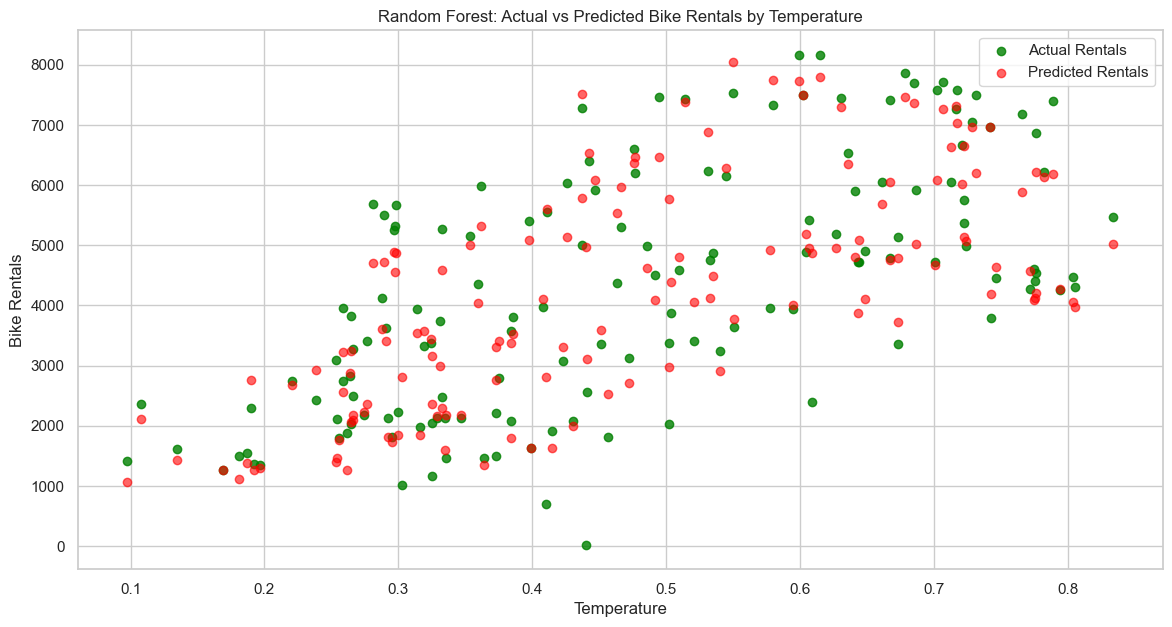

In [70]:
from sklearn.ensemble import RandomForestRegressor

# Create and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
X = bike_data[['yr', 'atemp', 'instant', 'temp', 'season', 'mnth', 'windspeed', 'weathersit']]
y = bike_data['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

# Visualize results
plt.figure(figsize=(14, 7))
plt.scatter(X_test['temp'], y_test, color='green', label='Actual Rentals', alpha=0.8)
plt.scatter(X_test['temp'], rf_pred, color='red', label='Predicted Rentals', alpha=0.6)
plt.title('Random Forest: Actual vs Predicted Bike Rentals by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Bike Rentals')
plt.legend()
plt.show()

### Performance Comparison: Linear Regression vs Random Forest

The Random Forest model shows significant improvements over our Linear Regression model:

#### Random Forest Performance:
- R² = 0.840 (84.0% accuracy)
- MSE = 641,314
- Average error ≈ 801 bikes per day

#### Linear Regression Performance (previous model):
- R² = 0.730 (73.0% accuracy)
- MSE = 1,081,936
- Average error ≈ 1,040 bikes per day

Key Improvements:
1. Accuracy increased by 11 percentage points
2. Mean Squared Error reduced by 40.7%
3. Average prediction error decreased by ~239 bikes per day

This improvement suggests that:
- Bike rental patterns have non-linear relationships that Random Forest captures better
- The additional complexity of Random Forest was worth the computational cost
- We might get even better results by tuning the Random Forest hyperparameters

### XGBoost Implementation

We'll now try XGBoost (eXtreme Gradient Boosting), an advanced implementation of gradient boosting machines that often performs better than Random Forest. The model includes:

1. Key parameters:
   - 100 estimators (trees)
   - Learning rate of 0.1
   - Maximum tree depth of 5

2. Using the same features:
   - Weather conditions (temp, atemp, windspeed, weathersit)
   - Temporal features (yr, instant, season, mnth)

We'll compare its performance with our previous models to see if we get better predictions.

Mean Squared Error (MSE): 493300.85800709255
R-squared (R²): 0.8769786953926086


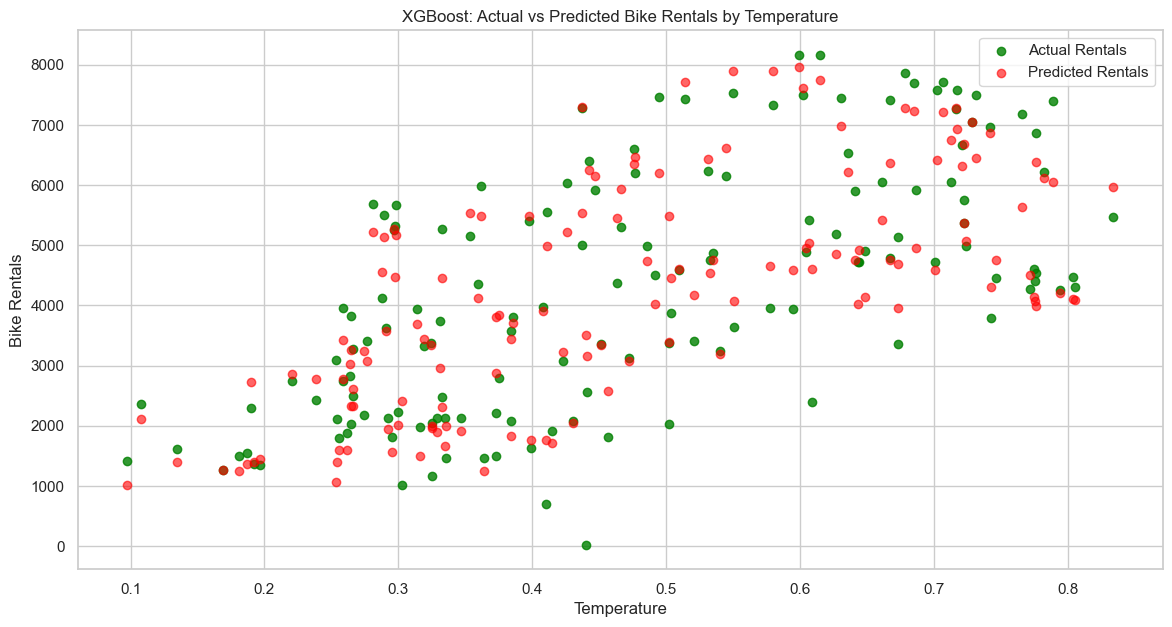

In [83]:
from xgboost import XGBRegressor

# Prepare the data with the same features we used
X = bike_data[['yr', 'atemp', 'instant', 'temp', 'season', 'mnth', 'windspeed', 'weathersit']]
y = bike_data['cnt']  

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

# Visualize results
plt.figure(figsize=(14, 7))
plt.scatter(X_test['temp'], y_test, color='green', label='Actual Rentals', alpha=0.8)
plt.scatter(X_test['temp'], xgb_pred, color='red', label='Predicted Rentals', alpha=0.6)
plt.title('XGBoost: Actual vs Predicted Bike Rentals by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Bike Rentals')
plt.legend()
plt.show()

### Model Performance Comparison

Let's compare the performance of all three models:

#### 1. XGBoost Model (Best):
- R² = 0.877 (87.7% accuracy)
- MSE = 493,301
- Average error ≈ 702 bikes per day

#### 2. Random Forest:
- R² = 0.840 (84.0% accuracy)
- MSE = 641,314
- Average error ≈ 801 bikes per day

#### 3. Linear Regression:
- R² = 0.730 (73.0% accuracy)
- MSE = 1,081,936
- Average error ≈ 1,040 bikes per day

Key Findings:
1. XGBoost improved accuracy by:
  - 3.7 percentage points over Random Forest
  - 14.7 percentage points over Linear Regression
2. MSE reduced by:
  - 23.1% compared to Random Forest
  - 54.4% compared to Linear Regression
3. Each model showed significant improvements over the previous one

XGBoost's superior performance demonstrates that the bike rental patterns have complex, non-linear relationships that this advanced algorithm can capture better than simpler models.

### Final Model Results and Conclusions

After testing three different models on our bike rental prediction task, we achieved the following results:

1. Linear Regression:
   - R² = 0.730 (73.0% accuracy)
   - MSE = 1,081,936

2. Random Forest:
   - R² = 0.840 (84.0% accuracy)
   - MSE = 641,314

3. XGBoost (Best Model):
   - R² = 0.877 (87.7% accuracy)
   - MSE = 493,301

XGBoost provided the best results, demonstrating that:
- The relationship between our features and bike rentals is non-linear
- Advanced ensemble methods handle these complex patterns better
- Weather and temporal features are good predictors of bike rental demand

This model could be valuable for bike sharing services to predict and prepare for daily rental demand based on weather forecasts and seasonal patterns.